<a href="https://colab.research.google.com/github/aayamneupane/Abductive-Learning-and-CNN/blob/master/AbductiveLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -q /content/drive/MyDrive/AbductiveLearning/dataset.zip
!pip install zoopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 665.9 kB/s eta 0:00:00


In [ ]:
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
%matplotlib inline
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard
import torchvision
import torch
random.seed(10)
writer = SummaryWriter()

def generate_equations(min_len=1,max_len=8,no_of_samples=6600,operator='xor'):
    '''
    Generates equations of the form X+Y=Z, where X,Y,Z are binary numbers and + represents the 'xor' operator
    The number of bits in each number will be between min_len and max_len
    Total number of equations generated will be no_of_samples
    '''
    equations=[]
    labels=[]
    for i in range(no_of_samples):
      # print(i)
      len=random.randint(min_len,max_len)
      left_op=random.randint(1,(2**len)-1)
      right_op=random.randint(1,(2**len)-1)
      if i%2==0:
      # if i%5!=0:
        result=left_op^right_op
        labels.append(1)
      else:
        result=random.randint(1,(2**len)-1)
        while(result==left_op^right_op):
          result=random.randint(1,(2**len)-1)
        labels.append(0)
      equation=""
      equation+=str(bin(left_op).replace("0b", "")).zfill(len)
      equation+="+"
      equation+=str(bin(right_op).replace("0b", "")).zfill(len)
      equation+="="
      equation+=str(bin(result).replace("0b", "")).zfill(len)
      equations.append(equation)
    return equations,labels

def generate_equation_images(eqs,signs,shape,image_pools):
  '''
  Given a set of equations in the form of strings. For ex. '1110+0001=1111', generate the corresponding handwritten equations,
  that is, replace the digits '1' and '0' with MNIST images and similarly for '+' and '='.
  '''
  sign_num = len(signs)
  char_index_dict = dict(zip(signs, list(range(sign_num))))
  eq_images=[]
  for eq in eqs:
    eq_image=[]
    for char in eq:
      index = char_index_dict[char]
      index2 = random.randint(0, len(image_pools[index]) - 1)
      image = Image.open(image_pools[index][index2]).convert('I').resize(shape)
      image_array = np.array(image)
      image_array = (image_array-127)*(1./128)
      eq_image.append(image_array)
    eq_images.append(np.array(eq_image))
    # print(eq_images[-1].shape)
  return eq_images


def get_image_pools(data_dir, sign_names):
    '''
    Load directories containing images into memory
    '''
    sign_num = len(sign_names)
    index_dict = dict(zip(sign_names, list(range(sign_num))))
    ret = [[] for _ in range(sign_num)]
    for path in os.listdir(data_dir):
        if (path in sign_names):
            index = index_dict[path]
            sign_path = os.path.join(data_dir, path)
            for p in os.listdir(sign_path):
                ret[index].append(os.path.join(sign_path, p))
    return ret

def split_pool(pools, rate):
  '''
  Split a pool of images into train and test sets.
  Ensures that the images used in equations of the test set, have not been seen
  '''
  train_pool = []
  test_pool  = []
  for pool in pools:
      random.shuffle(pool)
      num = int(len(pool) * rate)
      train_pool.append(pool[:num])
      test_pool.append(pool[num:])
  return train_pool, test_pool

def display_equations(eqs,labels):
  '''
  From a set of equations, display one positive and one negative sample on screen
  '''
  print("Positive Sample")
  first_1_idx = next((x for x in range(len(labels)) if labels[x]==1), None)
  display_multiple_img(eqs[first_1_idx],cols=eqs[first_1_idx].shape[0],text="Positive Sample")
  print("Negative Sample")
  # print(labels)
  first_0_idx = next((x for x in range(len(labels)) if labels[x]==0), None)
  display_multiple_img(eqs[first_0_idx],cols=eqs[first_0_idx].shape[0],text="Negative Sample")


def matplotlib_imshow(img, one_channel=False):
  '''
  helper function to show an image
  '''
  if one_channel:
      img = img.mean(dim=0)
  img = img / 128 + 127     # unnormalize
  npimg = img.numpy()
  if one_channel:
      plt.imshow(npimg, cmap="Greys")
  else:
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def display_multiple_img(images, rows = 1, cols=1,text=""):
  '''
  Display an equation on screen
  '''
  images=np.reshape(images,(images.shape[0],1,images.shape[1],images.shape[2]))
  img_grid = torchvision.utils.make_grid(torch.tensor(images),nrow=30)
  matplotlib_imshow(img_grid, one_channel=True)



In [ ]:
from sklearn.model_selection import train_test_split
eqs,labels=generate_equations()
print(eqs)
print(labels)
train_eqs,test_eqs,train_labels,test_labels=train_test_split(eqs,labels,train_size=0.8)
image_pools = get_image_pools("/content/dataset/mnist_images", ['0', '1', '10', '11'])
train_pool, test_pool = split_pool(image_pools, 0.8)
train_eq_images=generate_equation_images(train_eqs,['0', '1', '+', '='],(28,28),train_pool)
test_eq_images=generate_equation_images(test_eqs,['0', '1', '+', '='],(28,28),test_pool)

['1+1=0', '1+1=1', '10101+11010=01111', '001+101=011', '01+11=10', '000011+011011=111000', '101+011=110', '0110110+0100101=1101010', '01111+00110=01001', '10110+01100=00101', '11000101+11011101=00011000', '1000+1010=0111', '1+1=0', '010+011=101', '110010+111010=001000', '0110+1011=1001', '01110000+01111001=00001001', '11+11=10', '111+010=101', '0011111+0000101=0000101', '01001110+11010010=10011100', '11+01=01', '1001001+1111010=0110011', '111011+100111=001010', '01+10=11', '111+010=011', '1111101+0110110=1001011', '00111111+10101111=01000111', '101+101=000', '111+001=011', '01001110+00101011=01100101', '111+010=100', '010101+011100=001001', '0001+1001=1100', '1+1=0', '0010+0101=1000', '1001011+0010101=1011110', '1110110+1110000=1000000', '1100+1001=0101', '10001+10000=10100', '00010001+00101011=00111010', '10101101+01110111=11100110', '0010010+0110110=0100100', '100011+011001=100000', '101+100=001', '10+01=01', '10001010+00010001=10011011', '1+1=1', '11+10=01', '00100100+01110110=11011

Positive Sample


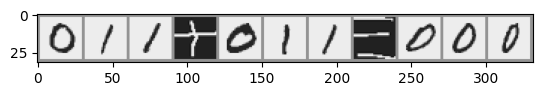

Negative Sample


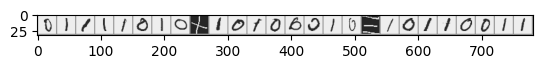

In [ ]:
display_equations(train_eq_images,train_labels)

# CNN

In [ ]:
import torch

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 4)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()
        # self.criterion = torch.nn.CrossEntropyLoss()
        # self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

    def train(self,X,y,epochs,optimizer,criterion):
      losses=[]
      for i in range(epochs):
        optimizer.zero_grad()
        pred = self(X)
        # print(pred,y)
        loss = criterion(pred, y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
      # plt.plot(losses)
      return np.array(losses)

**Abductive Learning**


In [ ]:
def check_f(left_op,right_op,result,f):
  '''
  Checks if f(left_op,right_op) is equal to result or not
  Returns 1 if yes, 0 otherwise
  '''
  if len(left_op)!=len(right_op):
    return -1
  if len(right_op)!=len(result):
    return -1
  func=np.zeros((2,2))
  func[0][0]=f % 2
  f=f>>1
  func[0][1]=f%2
  f=f>>1
  func[1][0]=f%2
  f=f>>1
  func[1][1]=f%2
  # print(func)
  # print(left_op,right_op,result)
  for a,b,c in zip(left_op,right_op,result):
    # print("yoo",a,b,c)
    if func[int(a)][int(b)]!=int(c):
      return 0
  return 1

def evaluate(eq,f):
  '''
  Check whether a given equation is consistent given an operator f
  Returns 1 if consistent ,0 if not consistent and -1 if equation does not have correct structure
  '''
  left_op=[]
  right_op=[]
  result=[]
  i=0
  while i<len(eq) and eq[i]!=2:
    if eq[i]==3:
      return -1
    else:
      left_op.append(eq[i])
    i+=1
  if i==len(eq):
    return -1
  i+=1

  while i<len(eq) and eq[i]!=3:
    if eq[i]==2:
      return -1
    else:
      right_op.append(eq[i])
    i+=1
  if i==len(eq):
    return -1
  i+=1

  while i<len(eq):
    if eq[i]>=2:
      return -1
    else:
      result.append(eq[i])
    i+=1
  # print(left_op,right_op,result)
  return check_f(left_op,right_op,result,f)

In [ ]:
def modify_equation(eq):
    '''
    Assign the value of '+' and '='  at the correct positions
    '''
    length=len(eq)
    size_of_num=int((length-2)/3)
    eq[size_of_num]=2
    eq[2*size_of_num+1]=3
    return eq

def modify(eqs):

  ans=[]
  for eq in eqs:
    ans.append(modify_equation(eq))
  return ans

def consistency_score(eqs,labels,background_knowledge=True):
  max=0
  best_f=-1
  best_eqs=[]
  for f in range(16):
    count=0
    correct_eqs=[]
    i=0
    for eq,label in zip(eqs,labels):
      if background_knowledge:
        eq=modify_equation(eq)
      if evaluate(eq,f)==label:
        count+=1
        correct_eqs.append(i)
      i+=1
    if count>max:
      best_f=f
      max=count
      best_eqs=correct_eqs
  return (max,best_f,best_eqs)


**Optimization**



In [ ]:
from collections import Counter
def reshape(eqs,flat_eqs):
  ans=[]
  i=0
  for eq in eqs:
    ans.append(flat_eqs[i:i+len(eq)])
    i+=len(eq)
  return ans

def reshape_and_get_score(eqs,flat_eqs,labels,background_knowledge=True):

  reshaped_eqs=reshape(eqs,flat_eqs)
  return consistency_score(reshaped_eqs,labels,background_knowledge)

def constraint(solution,ratio,og):

    # print("solution=",solution.get_x())
    # print("og=",og,"ratio=",ratio)
    max_diff=ratio*len(og)
    count=0
    for a,b in zip(solution.get_x(),og):
      if a!=b:
        count+=1
    # print("diff=",max_diff-count)
    return max_diff-count

def greedy_step(eqs,res,labels):

  max_score=reshape_and_get_score(eqs,res,labels)[0]
  best_index=-1
  for i in range(len(res)):
    temp=res[i]
    res[i]=0 if res[i]>0 else 1
    score=reshape_and_get_score(eqs,res,labels)[0]
    res[i]=temp
    if score>max_score:
      max_score=score
      best_index=i
  if best_index > -1:
    res[best_index]=0 if res[best_index]>0 else 1
  return res

def optimize_greedy(eqs,res,labels):

  for i in range(int(len(res)/10)):
    res=greedy_step(eqs,res,labels)
  return res


def optimize_minibatch(eqs,res,labels,budget,constraint=None,background_knowledge=True,greedy=False):
  if greedy:
    return optimize_greedy(eqs,res,labels)
  dim_size = 1 if background_knowledge else 3
  dim = Dimension(len(res), [[0, dim_size]] * len(res),[False] * len(res))
  obj = Objective(lambda x: -reshape_and_get_score(eqs,x.get_x(),labels,background_knowledge)[0],dim,constraint=constraint)
  param = Parameter(budget=budget, autoset=True)
  solution = Opt.min(obj, param)
  return solution

def decode(eqs,debug=False):
  ans=[]
  for eq in eqs:
    temp=''
    if debug:
      print(eq)
    for label in eq:
      if label<=1:
        temp+=str(int(label))
      elif label==2:
        temp+='+'
      else:
        temp+='='
    ans.append(temp)
  return ans

Training

In [ ]:
from zoopt import Dimension, Objective, Parameter, Opt, Solution
from itertools import chain
from functools import partial
import math
import copy
def train_minibatch(model,train_eq_images,train_eqs,train_labels,batch_size,no_of_epochs_outer=100,no_of_epochs_inner=10,budget=100,constr=1,background_knowledge=True,greedy=False,best_model=False,text="Default"):
  '''
  Trains a model using the Abductive Learning procedure defined above.

  no_of_epochs_outer specifies the number of iterations to run in outer loop
  no_of_epochs_inner specifies the number of iterations to train the CNN model in each iteration of the outer loop
  budget - used by optimization module
  constr - specifies the ratio of elements which can be changed by the optimization module
  background_knowledge - if this is true, it assumes the length of each number in an equation is constant
  greedy - if this is True, it uses greedy algorithm for optimization instead of RACOS/POSS
  best_model - if this is True, it returns model which had minimum loss during entire training process, else it returns the model at the end of the training process

  Returns the model after training and a list containing loss at each iteration
  '''
  optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
  losses=[]
  min_loss=math.inf
  best_model=model
  for i in range(no_of_epochs_outer):
    print("iteration #",i)
    # sample a batch of equations
    indices=random.sample(range(len(train_eq_images)),batch_size)
    eqs=[train_eq_images[i] for i in indices]
    eqs_expected=[train_eqs[i] for i in indices]
    flatten_eqs = list(chain.from_iterable(eqs))
    print("the equations in this batch are",eqs_expected)
    flatten_eqs=np.array(flatten_eqs)
    flatten_eqs=torch.tensor(flatten_eqs.reshape((flatten_eqs.shape[0],1,flatten_eqs.shape[1],flatten_eqs.shape[2])))
    labels=[train_labels[i] for i in indices]
    # get the  consistency score before optimization
    res=model(flatten_eqs.float())
    res=np.argmax(res.detach(),axis=1)
    print("equations before opti",decode(reshape(eqs,res.detach())))
    print("labels=",labels)
    c_score=-reshape_and_get_score(eqs,res,labels,background_knowledge)[0]
    print("c-score before opti",c_score)
    # optimize labels
    if constr==1 or i==0:
      c=None
    else:
      c=partial(constraint,ratio=constr,og=res)
    optimized_res=optimize_minibatch(eqs,res,labels,budget=budget,constraint=c,background_knowledge=background_knowledge,greedy=greedy if i else False)
    soln = optimized_res if greedy and i else optimized_res.get_x()
    if background_knowledge:
      print("equation after opti",decode(modify(reshape(eqs,soln)),debug=False))
    else:
      print("equation after opti",decode(reshape(eqs,soln),debug=False))
    # get consistency score after opti
    if (constr==1 and not greedy) or i==0:
      c_score_new=optimized_res.get_value()
    elif greedy:
      c_score_new=-reshape_and_get_score(eqs,soln,labels,background_knowledge=True)[0]
    else:
      if optimized_res.get_value()[1]<0:
        c_score_new=0.0
      else:
        c_score_new=optimized_res.get_value()[0]
    print("c-score after opti",c_score_new)
    if c_score_new>=c_score:
      print("skipping \n\n\n")
      continue
    ### Retrain model on new labels
    reshaped_ans=reshape(eqs,soln)
    correct_indices=consistency_score(reshaped_ans,labels)[2]
    correct_eqs=modify([reshaped_ans[i] for i in correct_indices]) if background_knowledge else [reshaped_ans[i] for i in correct_indices]
    correct_eq_images=[eqs[i] for i in correct_indices]
    print("Correct eqs=",decode(correct_eqs))
    flattened_correct_eqs=list(chain.from_iterable(correct_eqs))
    flattened_correct_eq_images=list(chain.from_iterable(correct_eq_images))
    flattened_correct_eq_images=np.array(flattened_correct_eq_images)
    print(flattened_correct_eq_images.shape)
    counts=Counter(np.array(flattened_correct_eqs))
    # print(counts)
    weight=torch.tensor([1/counts[0] if counts[0]>0 else 1,1/counts[1] if counts[1]>0 else 1,1/counts[2],1/counts[3]])
    criterion = torch.nn.CrossEntropyLoss(weight=weight)
    flattened_correct_eq_images=torch.tensor(flattened_correct_eq_images.reshape((flattened_correct_eq_images.shape[0],1,flattened_correct_eq_images.shape[1],flattened_correct_eq_images.shape[2])))
    loss=model.train(flattened_correct_eq_images.float(), torch.tensor(flattened_correct_eqs).long(),no_of_epochs_inner,optimizer,criterion)
    loss=loss/len(res)
    if min_loss>loss[-1]/len(res):
      best_model=copy.deepcopy(model)
      min_loss=loss[-1]/len(res)
    print("final loss=",loss/len(res))
    losses.append(loss[-1])
    writer.add_scalar("%s/train" %(text), loss[-1], i)
    print("model predictions after opti:",decode(reshape(correct_eq_images,np.argmax(model(flattened_correct_eq_images.float()).detach(),axis=1))))
    print("\n\n\n")
  if best_model:
    return best_model,losses
  return model,losses

iteration # 0
the equations in this batch are ['0100110+0010011=0110101', '1+1=1', '01+10=01', '1+1=1', '1001100+1100101=0101001', '1+1=1', '1101011+1100110=1001011', '0001+0001=1101', '10010010+10010110=00000100', '1001+0011=0110', '10+10=00', '1+1=0', '1+1=0', '10001+00001=01101', '01+11=10', '10010010+00100011=00000101']
equations before opti ['+====10001=00100+0=0==0', '=1==1', '+=11=00=', '1==1=', '0111==11=101=+0001=1+1=', '=1==1', '==0++++1==+=11=11=+=000', '0=1+0+==1=0=0+', '1==1111=0=1=++111=10======', '=+0+1001=0=0==', '1+00==1=', '01=0=', '00=+1', '=+1=00=====+=1==1', '01+10+=1', '===1101=1=+=1==+0010======']
labels= [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0]
c-score before opti 0
[zoopt] x: [1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,

Text(0, 0.5, 'CNN Training Loss')

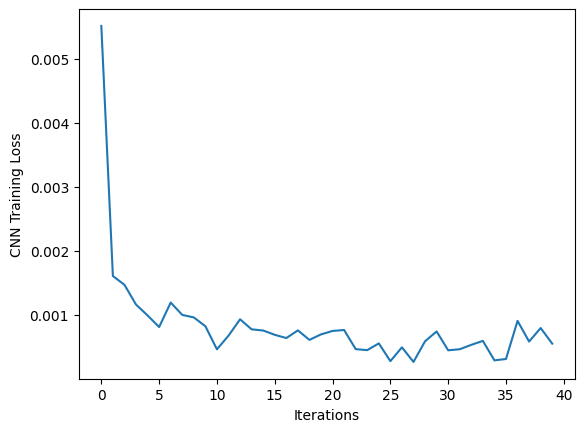

In [ ]:
model=Model()
model,losses=train_minibatch(model,train_eq_images,train_eqs,train_labels,16,100,10,budget=1000,constr=0.1,text="ABL")
writer.flush()
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("CNN Training Loss")
# train_sgd(model,train_eq_images,train_labels,100,10)

Evaluation

In [ ]:
def eval(eq_images,labels,model,background_knowledge=True):
  '''
  Given a set of equations and the corresponding labels, find the consistency score if 'model' is used for perception.
  '''
  eqs=[]
  i=0
  for eq_image in eq_images:
    # print(i)
    i+=1
    eq_image=torch.tensor(eq_image.reshape((eq_image.shape[0],1,eq_image.shape[1],eq_image.shape[2])))
    res=model(eq_image.float())
    res=np.argmax(res.detach(),axis=1)
    eqs.append(res)
  ans=consistency_score(eqs,labels,background_knowledge)
#   print(ans)
  counts=Counter(labels)
  count0=counts[0]
  count1=counts[1]
  correct_labels=[labels[i] for i in ans[2]]
  correct_counts=Counter(correct_labels)
  correct0=correct_counts[0]
  correct1=correct_counts[1]
  accuracy=(correct0+correct1)/(count0+count1)
  precision=float(correct1)/(correct1+count0-correct0)
  recall=float(correct0)/(correct0+count1-correct1)
  print("%f %f %d %d" %(precision,recall,correct0,correct1))
  if precision+recall>0:
    f1_score=2*(precision*recall)/(precision+recall)
  else:
    f1_score=0
  print('No of zeros correctly classified: %d/%d, No of ones correctly classified = %d/%d Accuracy=%f' %(correct0,count0,correct1,count1,(correct0+correct1)/(count0+count1)))
  return [ans[1],accuracy,f1_score]

In [ ]:
result=eval(test_eq_images,test_labels,model)

0.994819 0.898785 666 576
No of zeros correctly classified: 666/669, No of ones correctly classified = 576/651 Accuracy=0.940909


In [ ]:
%tensorboard --logdir runs

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
class BiLSTM(torch.nn.Module):
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.lstm_1 = torch.nn.LSTM(7 * 7 * 64, 128,bidirectional=True)
        self.linear_2 = torch.nn.Linear(128*2, 2)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()
        # self.criterion = torch.nn.CrossEntropyLoss()
        # self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        x = x.reshape(x.size(0),1,x.size(1),x.size(2))
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0),1,-1)
        # print(x.shape)
        x = self.lstm_1(x)[0]
        # print(x.shape)
        x = torch.mean(x, 0)
        # print(x.shape)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

    def train(self,X,y,optimizer,criterion):
      X,y=X.to(device),y.to(device)
      optimizer.zero_grad()
      pred = self(X)
      # print(y)
      loss = criterion(pred, y.long())
      loss.backward()
      optimizer.step()
      return loss


BilSTM

In [ ]:
class BiLSTM(torch.nn.Module):
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.lstm_1 = torch.nn.LSTM(7 * 7 * 64, 128,bidirectional=True)
        self.linear_2 = torch.nn.Linear(128*2, 2)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()
        # self.criterion = torch.nn.CrossEntropyLoss()
        # self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        x = x.reshape(x.size(0),1,x.size(1),x.size(2))
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0),1,-1)
        # print(x.shape)
        x = self.lstm_1(x)[0]
        # print(x.shape)
        x = torch.mean(x, 0)
        # print(x.shape)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

    def train(self,X,y,optimizer,criterion):
      X,y=X.to(device),y.to(device)
      optimizer.zero_grad()
      pred = self(X)
      # print(y)
      loss = criterion(pred, y.long())
      loss.backward()
      optimizer.step()
      return loss


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train_lstm(lstm,train_eq_images,train_labels,no_of_epochs=800):
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.RMSprop(lstm.parameters(), lr=0.001)
  losses=[]
  for i in range(no_of_epochs):
    # print(i)
    index=random.choice(range(len(train_eq_images)))
    x=train_eq_images[index]
    y=train_labels[index]
    loss=lstm.train(torch.Tensor(x),torch.Tensor([y]),optimizer,criterion)
    losses.append(loss)
    writer.add_scalar("BiLSTM/train", loss, i)
  return losses

def test_lstm(lstm,test_eq_images,test_labels):
  preds=[]
  i=0
  for x in test_eq_images:
    # print(x)
    x=torch.Tensor(x)
    x=x.to(device)
    i+=1
    pred=lstm(x)
    pred=np.argmax(pred.cpu().detach(),axis=1)
    preds.append(pred)
  accuracy=accuracy_score(preds,test_labels)
  f1=f1_score(preds,test_labels)
  return [accuracy,f1]

In [ ]:
lstm=BiLSTM()
lstm.to(device)
losses=train_lstm(lstm,train_eq_images,train_labels,8000)
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("training loss")

In [ ]:
result=test_lstm(lstm,test_eq_images,test_labels)
row=["BiLSTM","Handwritten Equations","NA"]
row= row+result
df.loc[len(df.index)] = row